In [1]:
# DB 
import psycopg2
from django.conf import settings
from django.db.models import Case, IntegerField, Value

# Helpers
import numpy as np
from collections import Counter, defaultdict
import pickle
import rpy2

# Learning
from sklearn.cluster import AgglomerativeClustering

# Evaluation
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext rpy2.ipython

In [2]:
folder = "data/edm2020"

In [3]:
with open("%s/q_matrix.pkl" % folder, 'rb') as pklfile:
    q_matrix = pickle.load(pklfile)
q_matrix.shape

(14, 48)

In [4]:
np.savetxt("%s/q_matrix.csv" % folder, q_matrix, delimiter=",")

In [5]:
with open("%s/questions_idx.pkl" % folder, 'rb') as pklfile:
    questions_idx = pickle.load(pklfile)

questions_idx = np.asarray(questions_idx)
questions_idx.shape

FileNotFoundError: [Errno 2] No such file or directory: 'data/edm2020/question_idx.pkl'

In [5]:
connection = psycopg2.connect(user = settings.DATABASES["default"]["USER"],
                                  password = settings.DATABASES["default"]["PASSWORD"],
                                  host = settings.DATABASES["default"]["HOST"],
                                  port = settings.DATABASES["default"]["PORT"],
                                  database = settings.DATABASES["default"]["NAME"])
connection.autocommit=True
cursor = connection.cursor()

In [6]:
%%R
library(factoextra)
library(proxy)

R[write to console]: Loading required package: ggplot2

R[write to console]: Keep up to date with changes at https://www.tidyverse.org/blog/

R[write to console]: Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

R[write to console]: 
Attaching package: ‘proxy’


R[write to console]: The following objects are masked from ‘package:stats’:

    as.dist, dist


R[write to console]: The following object is masked from ‘package:base’:

    as.matrix




In [7]:
%%R
getwd()

[1] "/home/lmoraes/machine-teaching/machineteaching"


In [8]:
%%R -o clusters
data <- read.csv('data/edm2020/q_matrix.csv', header=FALSE)
data <- as.data.frame(t(as.matrix(data)))

res.dist <- dist(data, method = "jaccard")
res.hc <- hclust(d=res.dist, method = "ward.D2")

options(repr.plot.width=4, repr.plot.height=3)
clusters <- cutree(res.hc, 9)

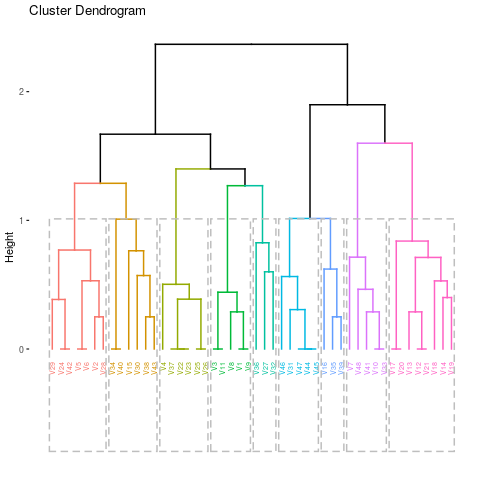

In [9]:
%%R
fviz_dend(res.hc, 
          k = 9,
          cex = 0.5, 
          color_labels_by_k = TRUE,
          rect = TRUE)

In [10]:
clusters

array([1, 2, 1, 3, 2, 2, 4, 1, 1, 4, 1, 5, 5, 5, 6, 7, 5, 5, 5, 5, 5, 3,
       3, 2, 3, 3, 8, 2, 2, 6, 9, 8, 4, 6, 7, 8, 3, 6, 7, 6, 4, 2, 6, 9,
       9, 9, 9, 4], dtype=int32)

In [11]:
unique_clusters = set(clusters)
unique_clusters

{1, 2, 3, 4, 5, 6, 7, 8, 9}

Redoing attempts statistics

In [12]:
# Filter used problems and solutions
last_id = 132
problems = Problem.objects.filter(id__lte=last_id)
solutions = Solution.objects.filter(problem__in=problems, ignore=False).values_list('problem', flat=True)
problems = solutions.order_by('problem').values_list(
    'problem', flat=True).distinct('problem')
print("Total number of questions: %d" % problems.count())

# Get all students
user_blacklist = UserProfile.objects.filter(professor__user__username='sem_professor')

attempts = UserLog.objects.exclude(outcome='S').filter(
    timestamp__lt=OuterRef('timestamp'), user__id=OuterRef('user__id')).annotate(
    attempt=Count('*')).values('attempt')

# Remove group by values
attempts.query.set_group_by()

# Get users
users = UserLog.objects.filter(problem__in=problems).exclude(outcome='S').exclude(
    user__userprofile__in=user_blacklist).annotate(
    attempt=Subquery(attempts, output_field=IntegerField())).annotate(
    score=Case(
        When(outcome='F', then=Value(0.1)),
        When(outcome='P', then=Value(1)),
        output_field=IntegerField())).values_list(
    "user__id", "problem_id", "attempt", "score"#"outcome", "timestamp"
).order_by("timestamp").filter(attempt=1).values_list('user_id', flat=True)

cluster_data = UserLog.objects.filter(problem__in=problems).exclude(outcome='S').annotate(
    attempt=Subquery(attempts, output_field=IntegerField())).annotate(
    score=Case(
        When(outcome='F', then=Value(0)),
        When(outcome='P', then=Value(1)),
        output_field=IntegerField())).order_by("timestamp").filter(user__in=users)

attempts_total = cluster_data.count()
print("Total number of attempts: %d" % attempts_total)

Total number of questions: 48
Total number of attempts: 3632


In [13]:
# Get voted concepts per solution
concepts = SolutionConcept.objects.all()
count = concepts.values_list('solution').annotate(count=Count('user', distinct=True))
sol_id, eval_count = zip(*list(count))

# Get voted concepts per problem
concepts = SolutionConcept.objects.all()
count = concepts.values_list('solution__problem').annotate(count=Count('user', distinct=True))
sol_id, eval_count = zip(*list(count))

# Count concept agreement per problem
count_per_problem = dict(concepts.values_list('solution__problem').annotate(
    count=Count('user', distinct=True)))

MIN_THRESHOLD = 0.5
agreed_concepts = defaultdict(list)
agreed_concepts_len = {}

# Filter out the concepts that didn't have agreement (50% of evaluators voted for it)
for problem in problems:
    max_votes = count_per_problem[problem]
    concepts_per_problem = dict(concepts.filter(solution__problem=problem).values_list('concept').annotate(
        count=Count("concept")))
    for concept, value in concepts_per_problem.items():
        if value >= (max_votes * MIN_THRESHOLD):
            agreed_concepts[problem].append(concept)
    agreed_concepts_len[problem] = len(agreed_concepts[problem])

In [21]:
points = []

success_per_question_cluster = defaultdict(dict)
for i, cluster in enumerate(unique_clusters):
    q_idx = questions_idx[np.where(clusters == cluster)]

    # Filter cluster problems
    problems = Problem.objects.filter(id__in=q_idx)
    print("Total number of questions: %d" % problems.count())
    
    # Get concepts
    concept_c = defaultdict(int)
    for problem in problems:
        print(agreed_concepts[problem.id])
        conc = agreed_concepts[problem.id]
        for c in conc:
            concept_c[c] += 1
    cs, votes = zip(*list(concept_c.items()))
    best_c = np.asarray(cs)[np.where(np.asarray(votes) == problems.count())]
    print(concept_c)

    # Get attempts
    attempts = cluster_data.filter(problem__in=problems).values_list(
        "user__id", "problem_id", "attempt", "score")
    
    # Get students
    user = set(cluster_data.filter(problem__in=problems).values_list('user__id', flat=True))
    
    attempts_count = attempts.count()
    attempts_avg = attempts_count/len(user)
#     users_total = users.count()
    success_attempts = attempts.filter(score=1)
    fail_attempts = attempts.filter(score=0)

    print("Total of %d attempts" % attempts_count)
    print("Total percentage of attempts: %.2f" % (attempts_count/attempts_total*100))
#     print("Total of %d students" % users_total)
#     print("Average of attempt per student: %.2f" % (attempts_total/users_total))
    success_perc = success_attempts.count()/attempts_count
    print("Success attempts: %d (%.2f%%)" % (success_attempts.count(), 100*success_perc))
#     print("Failed attempts: %d (%.2f%%)" % (fail_attempts.count(), 100*fail_attempts.count()/attempts_count))
#     print()
    
    success_per_student = defaultdict(int)
    fail_per_student = defaultdict(int)
    success_per_question = defaultdict(int)
    fail_per_question = defaultdict(int)

    for row in success_attempts:
        s_idx, q_idx, a_idx, outcome = row
        success_per_student[s_idx] += 1
        success_per_question[q_idx] += 1


    for row in fail_attempts:
        s_idx, q_idx, a_idx, outcome = row
        fail_per_student[s_idx] += 1
        fail_per_question[q_idx] += 1
        
    success_per_question_cluster[i] = success_per_question

#     min_student_success_attempt = min(success_per_student.values())
#     max_student_success_attempt = max(success_per_student.values())
#     avg_student_success_attempt = np.mean(list(success_per_student.values()))
#     min_student_fail_attempt = min(fail_per_student.values())
#     max_student_fail_attempt = max(fail_per_student.values())
#     avg_student_fail_attempt = np.mean(list(fail_per_student.values()))

    min_question_success_attempt = min(success_per_question.values())
    max_question_success_attempt = max(success_per_question.values())
    avg_question_success_attempt = np.mean(list(success_per_question.values()))
    median_question_success_attempt = np.median(list(success_per_question.values()))
    min_question_fail_attempt = min(fail_per_question.values())
    max_question_fail_attempt = max(fail_per_question.values())
    avg_question_fail_attempt = np.mean(list(fail_per_question.values()))
    median_question_fail_attempt = np.median(list(fail_per_question.values()))

#     print("Min student success attempt: %d" % min_student_success_attempt)
#     print("Max student success attempt: %d" % max_student_success_attempt)
#     print("Avg student success attempt: %.2f" % avg_student_success_attempt)

#     print("Min student fail attempt: %d" % min_student_fail_attempt)
#     print("Max student fail attempt: %d" % max_student_fail_attempt)
#     print("Avg student fail attempt: %.2f" % avg_student_fail_attempt)

#     print("Min question success attempt: %d" % min_question_success_attempt)
#     print("Max question success attempt: %d" % max_question_success_attempt)
#     print("Avg question success attempt: %.2f" % avg_question_success_attempt)
#     print("Median question success attempt: %.2f" % median_question_success_attempt)

#     print("Min question fail attempt: %d" % min_question_fail_attempt)
#     print("Max question fail attempt: %d" % max_question_fail_attempt)
#     print("Avg question fail attempt: %.2f" % avg_question_fail_attempt)
#     print("Median question fail attempt: %.2f" % median_question_fail_attempt)
    print("Number of students: %d" % len(user))
    print()
    
    points.append([attempts_avg, success_perc, len(user), best_c.tolist()])

Total number of questions: 5
[11, 8, 12]
[6, 11, 8, 12]
[11, 8, 12, 5]
[11, 8, 12]
[6, 11, 12, 8]
defaultdict(<class 'int'>, {11: 5, 8: 5, 12: 5, 6: 2, 5: 1})
Total of 355 attempts
Total percentage of attempts: 9.77
Success attempts: 86 (24.23%)
Number of students: 69

Total number of questions: 7
[11, 14, 12]
[11, 12, 5]
[11, 5, 12]
[12, 5]
[11, 14, 12, 5]
[14, 5, 12]
[12, 5]
defaultdict(<class 'int'>, {11: 4, 14: 3, 12: 7, 5: 6})
Total of 462 attempts
Total percentage of attempts: 12.72
Success attempts: 100 (21.65%)
Number of students: 77

Total number of questions: 6
[7, 11]
[11, 7, 12]
[11, 7, 12]
[6, 11, 7, 12]
[6, 11, 7, 12]
[11, 7, 12]
defaultdict(<class 'int'>, {7: 6, 11: 6, 12: 5, 6: 2})
Total of 454 attempts
Total percentage of attempts: 12.50
Success attempts: 93 (20.48%)
Number of students: 87

Total number of questions: 5
[14, 1, 8]
[14, 7, 8]
[14, 7, 8]
[14, 8, 7, 11]
[14, 7]
defaultdict(<class 'int'>, {14: 5, 1: 1, 8: 4, 7: 4, 11: 1})
Total of 189 attempts
Total percent

In [22]:
points

[[5.144927536231884, 0.24225352112676057, 69, [11, 8, 12]],
 [6.0, 0.21645021645021645, 77, [12]],
 [5.218390804597701, 0.20484581497797358, 87, [7, 11]],
 [4.973684210526316, 0.2328042328042328, 38, [14]],
 [6.383720930232558, 0.22950819672131148, 86, [11]],
 [8.473118279569892, 0.13959390862944163, 93, [12]],
 [5.738636363636363, 0.201980198019802, 88, [3, 5]],
 [7.6, 0.11578947368421053, 25, [13]],
 [2.9166666666666665, 0.5785714285714286, 48, [14, 3]]]

In [19]:
label_lookup[(11,)]

'Conditional'

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

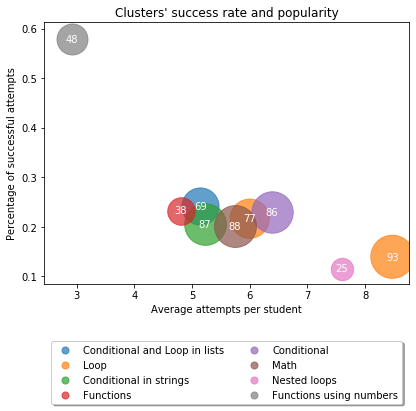

In [30]:
label_lookup = {(11,): "Conditional",
                (12,): "Loop",
                (11, 8, 12): "Conditional and Loop in lists",
                (7, 11): "Conditional in strings",
                (0,): "No agreement",
                (14, 3): "Functions using numbers",
                (14, ): "Functions",
                (3, 5): "Math",
                (13,): "Nested loops",
               }

labels = [item[3] for item in points]
unique_labels = []

for l in labels:
    if l not in unique_labels:
        unique_labels.append(l)

x = np.asarray([item[0] for item in points])
y = np.asarray([item[1] for item in points])
s = np.asarray([item[2] for item in points])

fig, ax = plt.subplots(figsize=(6,6))        
for l in unique_labels:
    idx = []
    for i, item in enumerate(points):
        if item[3] == l:
            idx.append(i)
    #   Hack to pretty print
    x[np.where(s == 38)] = 4.8
#     y[np.where(x == 462)] = 0.24
    
    try:
        label = label_lookup[tuple(l,)]
        ax.scatter(x[idx], y[idx], s[idx]*20, alpha=0.7, label=label)
    except KeyError:
        if not l:
            label = label_lookup[(0,)]
            
for idx in range(len(x)):
    text = ax.text(x[idx], y[idx], s[idx], ha="center", va="center", color="w")

ax.set_title("Clusters' success rate and popularity")
ax.set_xlabel("Average attempts per student")
ax.set_ylabel("Percentage of successful attempts")
# Put a legend below current axis
lgnd = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=2)
# lgnd = plt.legend()
for handle in lgnd.legendHandles:
    handle._sizes = [50]
    
plt.tight_layout()
plt.savefig('data/csedm2020/cluster_success.eps', format='eps')
plt.savefig('data/csedm2020/cluster_success.png', format='png')
plt.show()

So it is possible to think of it as four quadrants: on the top left are the easy questions (high successfully attempts percentage and attempts on average); on the bottom left are the medium questions (questions with low success rate but also a low attempts average); on the top right there are not any questions (it would be questions with high success rate but also a high number of tries, which in unlikely) and finally, on the bottom right are the questions where students have more difficulties. Analyzing by the quadrants, the gray cluster (top left) require the use of the ``Function'' concept, which are introductory CS1 exercises where the student is suppose to write a function with simple math operations directly in the return statement. The exercises belonging to this cluster are solved in smaller number of attempts and have a high success rate when compared to the other clusters. The clusters around 5 to 6.5 attempts on average are the very popular among students. They involve more advanced concepts such as strings, loops and conditionals and, on average, a student submits a correct response to them after 4 to 5 attempts. Finally, there are two clusters with more than 7 attempts on average per student and very low success rate. These clusters work on the ``Loop''  and ``Nested Loop'' concepts and have more complex problems than the other orange cluster.